In [1]:
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Import DATA

In [2]:
from google.colab import drive

drive.mount('/content/drive')

# importing the "tarfile" module
import tarfile
folder = '/content/drive/MyDrive/Applied Machine Learning/HW3/102flowers/'

# open file
file = tarfile.open(folder + '102flowers.tgz')

# extracting file
file.extractall('./102_oxford')

file.close()


Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
import shutil
import pathlib
import scipy.io


data_dir = '/content/102_oxford/jpg/'

mat = scipy.io.loadmat('/content/drive/MyDrive/Applied Machine Learning/HW3/102flowers/imagelabels.mat')

labels = mat['labels'].flatten()

X = range(1, len(labels) + 1)

X_train1, X_t, y_train1, y_t = train_test_split(X,labels,test_size=0.5)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_t,y_t,test_size=0.5)

X_train2, X_t2, y_train2, y_t2 = train_test_split(X,labels,test_size=0.5)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_t2,y_t2,test_size=0.5)

# def create_img_name(img_idx):
#     return 'image_' + f'{img_idx:05d}' + '.jpg'

def create_data_folder(indexes, labels, path):
    if os.path.exists(path):
         shutil.rmtree(path)
    
    for i in range(1, 103):
        pathlib.Path(path + '/' + str(i)).mkdir(parents=True, exist_ok=True) 

    for i, l in zip(indexes, labels):
        image_name = 'image_' + f'{i:05d}' + '.jpg'
        shutil.copy(data_dir + image_name, path + '/' + str(l))

# first split
create_data_folder(X_train1, y_train1, '/content/training1')
create_data_folder(X_val1, y_val1, '/content/validation1')
create_data_folder(X_test1, y_test1, '/content/testing1')

# second split
create_data_folder(X_train2, y_train2, '/content/training2')
create_data_folder(X_val2, y_val2, '/content/validation2')
create_data_folder(X_test2, y_test2, '/content/testing2')


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {'training1': datasets.ImageFolder('/content/training1', data_transforms['train']),
                  'validation1': datasets.ImageFolder('/content/validation1', data_transforms['val']),
                  'testing1': datasets.ImageFolder('/content/testing1', data_transforms['test']),
                  'training2': datasets.ImageFolder('/content/training2', data_transforms['train']),
                  'validation2': datasets.ImageFolder('/content/validation2', data_transforms['val']),
                  'testing2': datasets.ImageFolder('/content/testing2', data_transforms['test']),
                  }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=1)
              for x in ['training1', 'validation1', 'testing1', 'training2', 'validation2', 'testing2']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training1', 'validation1', 'testing1', 'training2', 'validation2', 'testing2']}

class_names = image_datasets['training1'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset sample

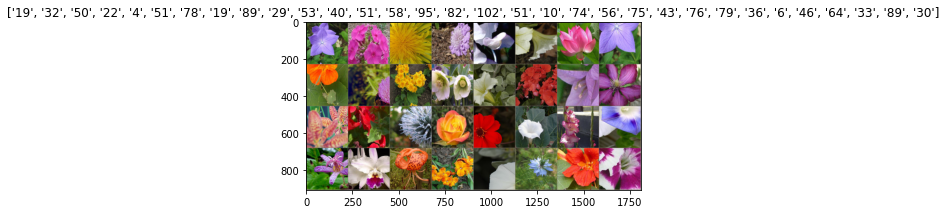

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['training1']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Train

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, run_id=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase+str(run_id)]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(f"outputs:{len(outputs)},\tlabels:{len(labels)}")
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase+str(run_id)]
            epoch_acc = running_corrects.double() / dataset_sizes[phase+str(run_id)]
            print(f'{phase+str(run_id)} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'training':
                epoch_train_loss.append(epoch_loss)
                epoch_train_acc.append(epoch_acc.cpu().detach().numpy().tolist()*100)
            else:
                epoch_val_loss.append(epoch_loss)
                epoch_val_acc.append(epoch_acc.cpu().detach().numpy().tolist()*100)

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    print()
    print()
    # loss graph
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_train_loss, label = 'train')
    plt.plot(epoch_val_loss, label = 'validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    
    # accuracy graph 
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_train_acc, label = 'train')
    plt.plot(epoch_val_acc, label = 'validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Model prediction

In [7]:
def int_to_onehot(y, num_labels):

    ary = np.zeros((len(y), num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
def evaluate(model, run_id):
  global labels
  model.to('cuda')
  pred = []
  true = []
  pred_probs = []
  with torch.no_grad():
      for inputs, classes in dataloaders['testing' + str(run_id)]:
          inputs, classes = inputs.to('cuda:0'), classes.to('cuda:0')
          model.to('cuda')
          output = model(inputs)
          _, predicted = torch.max(output.data, 1)
          pred += predicted.cpu().detach().numpy().tolist()
          true += classes.cpu().detach().numpy().tolist()
          pred_probs += output.cpu().detach().numpy().tolist()
  true_mat = int_to_onehot(true, 102)
  pred_mat = int_to_onehot(pred, 102)
  print("The accuracy for the test set is: {}".format(accuracy_score(true_mat, pred_mat)))
  print("The Cross-Entropy for the test set is: {}".format(log_loss(true, pred_probs,labels=labels)))

In [9]:
def visualize_model(model, num_images=6, run_id = 1):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation'+str(run_id)]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Model

ResNet18

In [10]:
def get_resnet18():
    model_conv = torchvision.models.resnet18(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Sequential(
                nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 102), nn.LogSoftmax(dim=1))


    model_conv = model_conv.to(device)

    criterion = nn.NLLLoss()
    optimizer_conv = optim.Adam(model_conv.fc.parameters())
    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    #optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    return model_conv, criterion, optimizer_conv, exp_lr_scheduler

run number 1

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/9
----------
training1 Loss: 3.7610 Acc: 0.2008
validation1 Loss: 2.3563 Acc: 0.4773

Epoch 1/9
----------
training1 Loss: 2.1508 Acc: 0.5098
validation1 Loss: 1.2655 Acc: 0.6947

Epoch 2/9
----------
training1 Loss: 1.4609 Acc: 0.6402
validation1 Loss: 0.8210 Acc: 0.8100

Epoch 3/9
----------
training1 Loss: 1.1796 Acc: 0.6996
validation1 Loss: 0.6871 Acc: 0.8315

Epoch 4/9
----------
training1 Loss: 1.0091 Acc: 0.7379
validation1 Loss: 0.5695 Acc: 0.8520

Epoch 5/9
----------
training1 Loss: 0.9110 Acc: 0.7560
validation1 Loss: 0.4937 Acc: 0.8710

Epoch 6/9
----------
training1 Loss: 0.8667 Acc: 0.7616
validation1 Loss: 0.4543 Acc: 0.8847

Epoch 7/9
----------
training1 Loss: 0.7404 Acc: 0.8112
validation1 Loss: 0.3924 Acc: 0.8994

Epoch 8/9
----------
training1 Loss: 0.6983 Acc: 0.8178
validation1 Loss: 0.3792 Acc: 0.9013

Epoch 9/9
----------
training1 Loss: 0.6767 Acc: 0.8217
validation1 Loss: 0.3730 Acc: 0.9023

Training complete in 8m 16s
Best val Acc: 0.902296




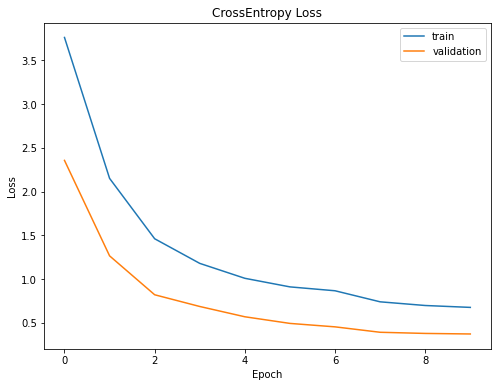

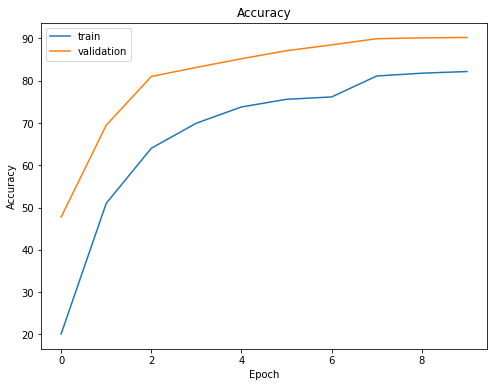

In [11]:
run_id = 1

model_conv, criterion, optimizer_conv, exp_lr_scheduler = get_resnet18()

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10, run_id=run_id)

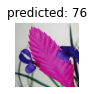

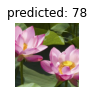

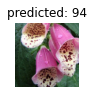

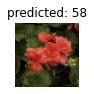

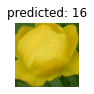

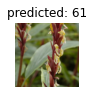

In [12]:
visualize_model(model_conv,run_id=run_id)

plt.ioff()
plt.show()

In [13]:
evaluate(model_conv,run_id)

The accuracy for the test set is: 0.89013671875
The Cross-Entropy for the test set is: 4.591098500686974


run number 2

Epoch 0/9
----------
training2 Loss: 3.7521 Acc: 0.2010
validation2 Loss: 2.5661 Acc: 0.4245

Epoch 1/9
----------
training2 Loss: 2.1877 Acc: 0.4924
validation2 Loss: 1.3309 Acc: 0.7030

Epoch 2/9
----------
training2 Loss: 1.5215 Acc: 0.6275
validation2 Loss: 0.9170 Acc: 0.7675

Epoch 3/9
----------
training2 Loss: 1.2433 Acc: 0.6786
validation2 Loss: 0.7220 Acc: 0.8178

Epoch 4/9
----------
training2 Loss: 1.0368 Acc: 0.7308
validation2 Loss: 0.5886 Acc: 0.8617

Epoch 5/9
----------
training2 Loss: 0.9419 Acc: 0.7509
validation2 Loss: 0.5481 Acc: 0.8539

Epoch 6/9
----------
training2 Loss: 0.8821 Acc: 0.7687
validation2 Loss: 0.5074 Acc: 0.8617

Epoch 7/9
----------
training2 Loss: 0.7675 Acc: 0.7946
validation2 Loss: 0.4170 Acc: 0.8925

Epoch 8/9
----------
training2 Loss: 0.6993 Acc: 0.8170
validation2 Loss: 0.4147 Acc: 0.8915

Epoch 9/9
----------
training2 Loss: 0.7287 Acc: 0.8102
validation2 Loss: 0.3961 Acc: 0.8950

Training complete in 8m 14s
Best val Acc: 0.894968




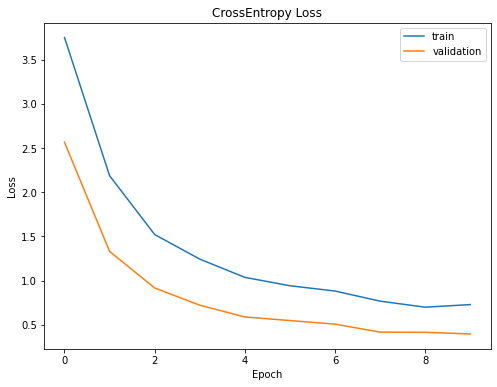

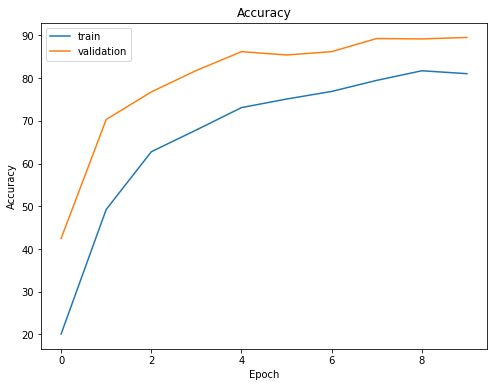

In [14]:
run_id = 2

model_conv, criterion, optimizer_conv, exp_lr_scheduler = get_resnet18()

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10, run_id=run_id)

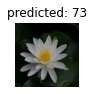

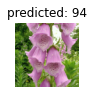

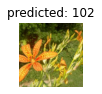

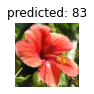

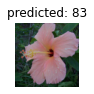

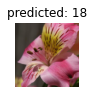

In [15]:
visualize_model(model_conv,run_id=run_id)

plt.ioff()
plt.show()

In [16]:
evaluate(model_conv,run_id)

The accuracy for the test set is: 0.884765625
The Cross-Entropy for the test set is: 4.602389938219407


VGG19

In [17]:
def get_vgg19():
    model_conv = torchvision.models.vgg19(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.classifier[6].in_features
    model_conv.classifier[6] = nn.Sequential(
                nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 102), nn.LogSoftmax(dim=1))


    model_conv = model_conv.to(device)

    criterion = nn.NLLLoss()
    optimizer_conv = optim.Adam(model_conv.classifier[6].parameters())
    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    #optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    return model_conv, criterion, optimizer_conv, exp_lr_scheduler

run number 1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch 0/9
----------
training1 Loss: 3.1718 Acc: 0.2948
validation1 Loss: 1.6965 Acc: 0.5848

Epoch 1/9
----------
training1 Loss: 1.7569 Acc: 0.5305
validation1 Loss: 1.1415 Acc: 0.7181

Epoch 2/9
----------
training1 Loss: 1.4681 Acc: 0.5955
validation1 Loss: 0.9715 Acc: 0.7323

Epoch 3/9
----------
training1 Loss: 1.2884 Acc: 0.6336
validation1 Loss: 0.8639 Acc: 0.7689

Epoch 4/9
----------
training1 Loss: 1.2380 Acc: 0.6544
validation1 Loss: 0.8435 Acc: 0.7699

Epoch 5/9
----------
training1 Loss: 1.1416 Acc: 0.6825
validation1 Loss: 0.8204 Acc: 0.7767

Epoch 6/9
----------
training1 Loss: 1.1240 Acc: 0.6815
validation1 Loss: 0.7706 Acc: 0.7929

Epoch 7/9
----------
training1 Loss: 1.0193 Acc: 0.7147
validation1 Loss: 0.6907 Acc: 0.8163

Epoch 8/9
----------
training1 Loss: 0.9646 Acc: 0.7215
validation1 Loss: 0.6665 Acc: 0.8236

Epoch 9/9
----------
training1 Loss: 0.9417 Acc: 0.7267
validation1 Loss: 0.6605 Acc: 0.8280

Training complete in 9m 49s
Best val Acc: 0.828041




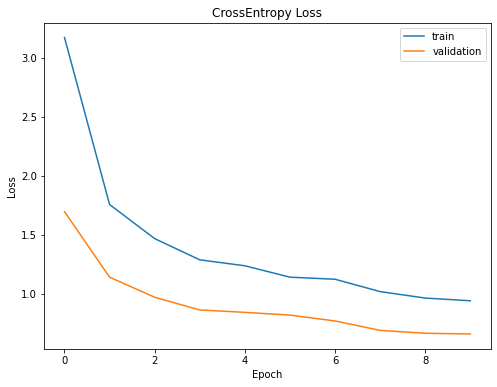

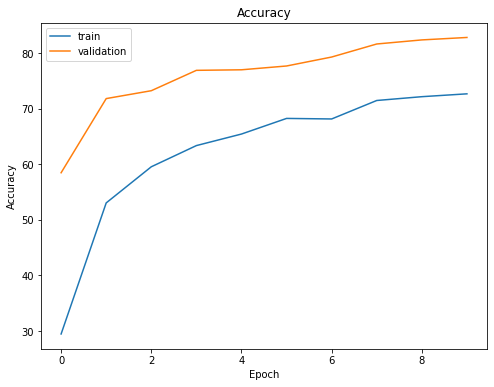

In [18]:
run_id = 1

model_conv, criterion, optimizer_conv, exp_lr_scheduler = get_vgg19()

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10, run_id=run_id)

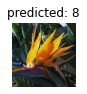

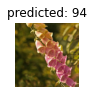

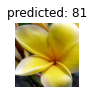

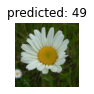

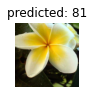

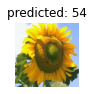

In [19]:
visualize_model(model_conv,run_id=run_id)

plt.ioff()
plt.show()

In [20]:
evaluate(model_conv,run_id)

The accuracy for the test set is: 0.83056640625
The Cross-Entropy for the test set is: 4.591098500686974


run number 2

Epoch 0/4
----------
training2 Loss: 3.0781 Acc: 0.3073
validation2 Loss: 1.6767 Acc: 0.5911

Epoch 1/4
----------
training2 Loss: 1.7488 Acc: 0.5362
validation2 Loss: 1.2024 Acc: 0.6913

Epoch 2/4
----------
training2 Loss: 1.4356 Acc: 0.6155
validation2 Loss: 1.0529 Acc: 0.7108

Epoch 3/4
----------
training2 Loss: 1.3248 Acc: 0.6353
validation2 Loss: 0.9371 Acc: 0.7382

Epoch 4/4
----------
training2 Loss: 1.2570 Acc: 0.6492
validation2 Loss: 0.8668 Acc: 0.7670

Training complete in 4m 53s
Best val Acc: 0.766976




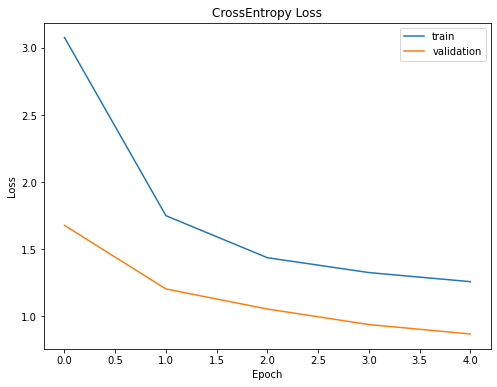

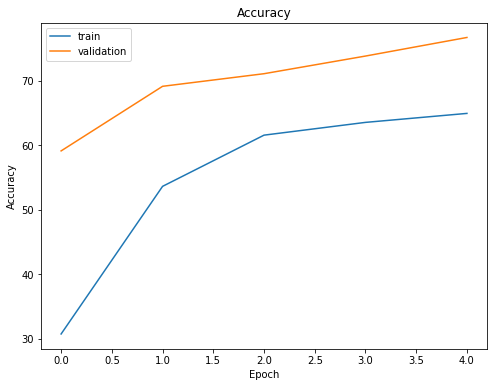

In [21]:
run_id = 2

model_conv, criterion, optimizer_conv, exp_lr_scheduler = get_vgg19()

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5, run_id=run_id)

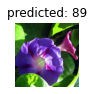

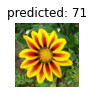

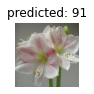

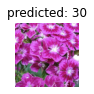

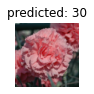

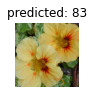

In [22]:
visualize_model(model_conv,run_id=run_id)

plt.ioff()
plt.show()

In [23]:
evaluate(model_conv,run_id)

The accuracy for the test set is: 0.76025390625
The Cross-Entropy for the test set is: 4.602389938219407
